# Scene configuration for 3D reconstruction of Atom Cloud

In this version, we simulate the image using the pin-hole model as a replacement of a lens

In [1]:
import gradoptics as optics
from gradoptics.transforms.simple_transform import SimpleTransform
from gradoptics.integrator import HierarchicalSamplingIntegrator

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import pickle
import cv2

/projects/p30957/envs/pytorch-1.11-py38-alt-2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import images from apparatus 
images were preprocessed and saved as pkl, with a range corresponds to unit8 ([0,255])

In [2]:
# this is in the order for camera: X1,X2,Y1,Z1
camera_list = ['T1_0','T2_0','L_0','F_0']
data_intensities_all = []

#load preprocessed images
for idx,cam in enumerate(camera_list): 
    with open(cam+'.pkl', 'rb') as f:
        data_intensities_all.append(pickle.load(f).T.astype(np.float64))
        

obtain shape of the image samples to be used as resolutions of corresponding cameras

In [3]:
cam_res = []
for i in range(len(camera_list)):
    cam_res.append(data_intensities_all[i].shape)

print(cam_res)

[(758, 800), (1000, 1066), (1400, 1100), (1600, 1600)]


## Camera parameters

In [4]:
def inch_to_m(inch):
    # 1 in is 2.54 cm
    return 0.0254*inch

In [5]:
obj_pos = torch.tensor([0., 0., 0.])

camera_dist_x1 = inch_to_m(5)
camera_dist_x2 = inch_to_m(2.5)
camera_dist_y1 = inch_to_m(3.5)
camera_dist_z1 = inch_to_m(2.5)

x1_to_center = inch_to_m(14.5)
x2_to_center = inch_to_m(14.5)
y1_to_center = inch_to_m(17.)
z1_to_center = inch_to_m(11.5)

# Angle from positive x-axis
angle_x1 = np.radians(53.) #37.
angle_x2 = np.radians(45.+180.)
angle_y1 = np.radians(-45.)

In [6]:
obj_pos = torch.tensor([0., 0., 0.])

camera_dist_x1 = inch_to_m(5)
camera_dist_x2 = inch_to_m(2.5)
camera_dist_y1 = inch_to_m(3.5)
camera_dist_z1 = inch_to_m(2.5)

x1_to_center = inch_to_m(14.5)
x2_to_center = inch_to_m(14.5)
y1_to_center = inch_to_m(17.)
z1_to_center = inch_to_m(11.5)

# Angle from positive x-axis
angle_x1 = np.radians(53.) #37.
angle_x2 = np.radians(45.+180.)
angle_y1 = np.radians(-45.)

In [7]:
camera_params = [
    {'name' : 'X_1', 
     'position' : ((x1_to_center+camera_dist_x1)*np.cos(angle_x1), 
                   0., (x1_to_center+camera_dist_x1)*np.sin(angle_x1)),
     'orientation' : (0, angle_x1+np.pi, 0), 
     'm' : 0.1, 
     'aperture' : inch_to_m(2.),
     'pixel_size':(3.45e-06, 3.45e-06),
     'resolution':cam_res[0],
     'distance':x1_to_center+camera_dist_x1,
    },
    
    {'name' : 'X_2', 
     'position' : ((x2_to_center+camera_dist_x2)*np.cos(angle_x2), 
                   0., (x2_to_center+camera_dist_x2)*np.sin(angle_x2)),
     'orientation' : (0, angle_x2+np.pi, 0),
     'm' : 0.089,
     'aperture' : inch_to_m(2.),
     'pixel_size':(3.45e-06, 3.45e-06),
     'resolution':cam_res[1],
     'distance':x2_to_center+camera_dist_x2
    },
    
    {'name' : 'Y_1', 
     'position' : ((y1_to_center+camera_dist_y1)*np.cos(angle_y1),
                   0, (y1_to_center+camera_dist_y1)*np.sin(angle_y1)),
     'orientation' : (0, angle_y1+np.pi, 0), 
     'm' : 0.088, 
     'aperture' : inch_to_m(2.),
     'pixel_size':(3.45e-06, 3.45e-06),
     'resolution':cam_res[2],
     'distance':y1_to_center+camera_dist_y1
    },
    
    {'name' : 'Z_1', 
     'position' : (0, (z1_to_center+camera_dist_z1), 0,),
     'orientation' : (0, 0, -np.pi/2),
     'm' : 0.11*2.4/3.45,
     'aperture' : inch_to_m(2.),
     'pixel_size':(3.45e-06, 3.45e-06),
     'resolution':cam_res[3],
     'distance':z1_to_center+camera_dist_z1
    }
]

In [8]:
def calculate_focal_length(m, obj_distance):
    f =  obj_distance / ((1 / m) + 1)
    return f

def calculate_obj_distance(obj_pos, camera_pos):
    return torch.sqrt(((torch.tensor(camera_pos)-obj_pos)**2).sum()).item()

In [9]:
for i in range(len(camera_params)):
    camera_params[i]['obj_dist'] = calculate_obj_distance(obj_pos, camera_params[i]['position'])
    camera_params[i]['f'] = calculate_focal_length(camera_params[i]['m'], 
                                                   camera_params[i]['obj_dist'])
    camera_params[i]['na'] = camera_params[i]['aperture']/camera_params[i]['f']

## Construct scene

In [10]:
# Atom cloud
light_source = optics.LightSourceFromDistribution(optics.AtomCloud(phi=0.1, w0=0.005, k_fringe=0,
                                                                   position=[0., 0., 0.]))

scene = optics.Scene(light_source)

# add cameras and lens to scene as objects (in world space)
for camera in camera_params:
    transform = SimpleTransform(*camera['orientation'], camera['position'])
    lens = optics.PerfectLens(f=camera['f'], m=camera['m'], na=camera['na'],
                              position = camera['position'],
                              transform=transform)
                              
    rel_position = torch.tensor([-camera['f'] * (1 + camera['m']), 0, 0])                       
    rot_position = torch.matmul(transform.transform.float(), torch.cat((rel_position, torch.tensor([0]))))
    
    sensor_position = torch.tensor(camera['position']) + rot_position[:-1]
    viewing_direction = torch.matmul(transform.transform.float(), torch.tensor([1.,0,0,0]))
    
    sensor = optics.Sensor(position=sensor_position, viewing_direction=tuple(viewing_direction.numpy()),
                           resolution=camera['resolution'], pixel_size=camera['pixel_size'],
                           poisson_noise_mean=2.31, quantum_efficiency=0.72)
    scene.add_object(sensor)
    scene.add_object(lens)


display geometric relation of all objects in the scene

/projects/p30957/envs/pytorch-1.11-py38-alt-2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1650922114512/work/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


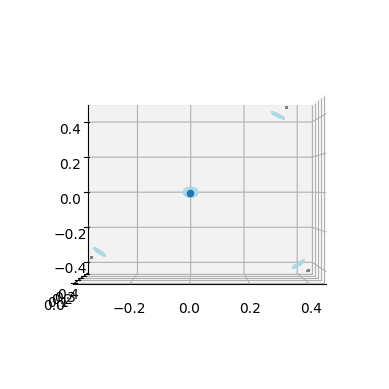

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scene.plot(ax)
ax.view_init(0, -90)

list of objects

In [12]:
scene.objects

Export scene model to be used for reconstruction

In [13]:
with open("NW_mot_scene_components.pkl", "wb") as f:
    pickle.dump(scene.objects, f)

## Simulation and Normalization for real data

In [14]:
# Define an integrator
integrator = HierarchicalSamplingIntegrator(64, 64)

# Define a bounding shape to integrate in
scene.light_source.bounding_shape = optics.BoundingSphere(radii=0.03, xc=0, yc=0, zc=0)

# Enclose the scene in a large bounding sphere
scene.add_object(optics.BoundingSphere(xc=0, yc=0, zc=0, radii=10.))

ray-trace using the pin-hole model

In [ ]:
pixel_batch = 200000
sim_intensities_all = []
for i,obj in enumerate(scene.objects):
    if type(obj) == optics.Sensor:
        sensor = scene.objects[i]
        lens = scene.objects[i+1]
        
        # Define pixel indices
        idxs = torch.cartesian_prod(torch.arange(sensor.resolution[0]//2, -sensor.resolution[0]//2, -1), 
                            torch.arange(sensor.resolution[1]//2, -sensor.resolution[1]//2, -1))

        pix_x, pix_y = idxs.T

        # Batch over them for rendering -- I used a large GPU
        batch_pix_x = pix_x.split(pixel_batch)
        batch_pix_y = pix_y.split(pixel_batch)

        intensities_all = []
        
        device = 'cuda'
        lens_pos = scene.objects[i+1].transform.transform[:-1, -1].to(device)       
        
        for j in tqdm(range(len(batch_pix_x))):
            nb_pixels = len(batch_pix_x[j])
                        
            origins = torch.zeros((nb_pixels,3),device = device,dtype = torch.float64)
            origins[:,0] = (batch_pix_x[j].to(device)-.5)* sensor.pixel_size[0]
            origins[:,1] = (batch_pix_y[j].to(device)-.5)* sensor.pixel_size[1]
            origins = sensor.c2w.apply_transform_(origins.reshape(-1, 3)).reshape((nb_pixels, 3))
            pA = 1 / (sensor.resolution[0] * sensor.pixel_size[0] * sensor.resolution[1] * sensor.pixel_size[1])         
            # directions of rays: from points on sensor to pin-hole
            directions = lens_pos - origins
            directions = directions/torch.norm(directions, dim=1, keepdim=True)  
           
            outgoing_rays = optics.Rays(origins, directions, device='cuda')
            intensities_all.append(optics.backward_ray_tracing(outgoing_rays,scene, scene.light_source,integrator, max_iterations=6))

        sim_intensities = torch.cat(intensities_all).reshape(sensor.resolution)
        sim_intensities_all.append(sim_intensities.clone())
        

 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.54it/s]

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(8, 2))
for i in range(len(sim_intensities_all)):
    im = ax[i].imshow(sim_intensities_all[i].cpu().T)
    ax[i].set_title(f"{camera_params[i]['name']}")
    ax[i].axis('off')
    #fig.colorbar(im)
    #im.set_clim(vmin = 0,vmax = 12700)
    
plt.tight_layout() 

### Normalize the max value for apparatus data according the simulation result

In [ ]:
data_intensities_all_n = []
for idx,cam in enumerate(camera_list):
    data_intensities_all_n.append(data_intensities_all[idx]*torch.max(sim_intensities_all[idx]).item()/255)

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(8, 2))
for i in range(len(camera_list)):
    im = ax[i].imshow(data_intensities_all_n[i].T)
    ax[i].axis('off')
    ax[i].set_title(camera_list[i])
    im.set_clim(vmin = 0,vmax = 12700)
plt.tight_layout()
#plt.savefig("camera_data", dpi=800)
plt.show()

In [ ]:
# export normalized data for use in reconstruction
with open("NW_mot_images.pkl", "wb") as f:
    pickle.dump(data_intensities_all_n, f)